# Basic engine implementation

#### setup

In [12]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test.mp4"
video_location = "test2.mp4"

[2021-04-17 10:20:40,867] [INFO] [<module>] [13] : Starting ...


## running evm pre-processing

In [13]:
#%run ./evm_preprocessing.ipynb
#video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [14]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [15]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [16]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [17]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [18]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [19]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
#     plt.imshow(roi)
#     plt.show()
    try:
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    except:
        return False, color_sig
    new_blue,new_green,new_red = cv2.split(roi)
    b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
    luminance_level = parse_luminace(r_mean, g_mean, b_mean)
    if good_frame(b_mean,g_mean,r_mean):
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0)
        color_sig.append(avg_color)
        return True, color_sig, luminance_level
    return False, color_sig, luminance_level

#### Main loop - going over all the frames of the video

In [20]:
color_sig = []
heart_rates = []
good_frame_number = 0
total_frame_number = 0

# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
        roi = np.asarray(rois[0]) # Just the forehead
        is_good_frame,color_sig, luminance_level = parse_RGB(roi, color_sig)
        if is_good_frame:
            good_frame_number += 1
            logging.info("luminance level: " + str(luminance_level))
    total_frame_number += 1
    success, image = get_new_frame(vidcap)

[2021-04-17 10:20:41,047] [INFO] [<module>] [7] : Working on video test2.mp4
[2021-04-17 10:20:41,121] [INFO] [<module>] [13] : Parsing images ...
[2021-04-17 10:20:41,122] [INFO] [<module>] [15] : parsing frame 0/239.0
[2021-04-17 10:20:42,575] [INFO] [<module>] [22] : luminance level: 196.9642874504443
[2021-04-17 10:20:42,578] [INFO] [<module>] [15] : parsing frame 1/239.0
[2021-04-17 10:20:44,161] [INFO] [<module>] [22] : luminance level: 196.78115368421052
[2021-04-17 10:20:44,165] [INFO] [<module>] [15] : parsing frame 2/239.0
[2021-04-17 10:20:45,589] [INFO] [<module>] [22] : luminance level: 197.14221805785127
[2021-04-17 10:20:45,596] [INFO] [<module>] [15] : parsing frame 3/239.0
[2021-04-17 10:20:47,010] [INFO] [<module>] [22] : luminance level: 196.78018069719752
[2021-04-17 10:20:47,015] [INFO] [<module>] [15] : parsing frame 4/239.0
[2021-04-17 10:20:48,241] [INFO] [<module>] [22] : luminance level: 197.21907708261318
[2021-04-17 10:20:48,244] [INFO] [<module>] [15] : par

[2021-04-17 10:21:48,841] [INFO] [<module>] [22] : luminance level: 196.94979892563373
[2021-04-17 10:21:48,846] [INFO] [<module>] [15] : parsing frame 51/239.0
[2021-04-17 10:21:50,260] [INFO] [<module>] [22] : luminance level: 196.96408984388114
[2021-04-17 10:21:50,264] [INFO] [<module>] [15] : parsing frame 52/239.0
[2021-04-17 10:21:51,685] [INFO] [<module>] [22] : luminance level: 197.09996460535592
[2021-04-17 10:21:51,692] [INFO] [<module>] [15] : parsing frame 53/239.0
[2021-04-17 10:21:53,094] [INFO] [<module>] [22] : luminance level: 195.6296940563426
[2021-04-17 10:21:53,102] [INFO] [<module>] [15] : parsing frame 54/239.0
[2021-04-17 10:21:54,631] [INFO] [<module>] [22] : luminance level: 196.0002426119647
[2021-04-17 10:21:54,636] [INFO] [<module>] [15] : parsing frame 55/239.0
[2021-04-17 10:21:56,393] [INFO] [<module>] [22] : luminance level: 195.73712056595923
[2021-04-17 10:21:56,402] [INFO] [<module>] [15] : parsing frame 56/239.0
[2021-04-17 10:21:58,473] [INFO] [<m

[2021-04-17 10:22:59,593] [INFO] [<module>] [22] : luminance level: 196.45845103386807
[2021-04-17 10:22:59,595] [INFO] [<module>] [15] : parsing frame 102/239.0
[2021-04-17 10:23:00,904] [INFO] [<module>] [22] : luminance level: 195.88164321375433
[2021-04-17 10:23:00,909] [INFO] [<module>] [15] : parsing frame 103/239.0
[2021-04-17 10:23:02,305] [INFO] [<module>] [22] : luminance level: 195.49701184577523
[2021-04-17 10:23:02,308] [INFO] [<module>] [15] : parsing frame 104/239.0
[2021-04-17 10:23:03,692] [INFO] [<module>] [22] : luminance level: 195.91388100949524
[2021-04-17 10:23:03,695] [INFO] [<module>] [15] : parsing frame 105/239.0
[2021-04-17 10:23:05,205] [INFO] [<module>] [22] : luminance level: 196.46410157264958
[2021-04-17 10:23:05,209] [INFO] [<module>] [15] : parsing frame 106/239.0
[2021-04-17 10:23:06,500] [INFO] [<module>] [22] : luminance level: 195.42617678424938
[2021-04-17 10:23:06,506] [INFO] [<module>] [15] : parsing frame 107/239.0
[2021-04-17 10:23:07,853] [I

[2021-04-17 10:24:06,837] [INFO] [<module>] [22] : luminance level: 197.2047398026598
[2021-04-17 10:24:06,843] [INFO] [<module>] [15] : parsing frame 153/239.0
[2021-04-17 10:24:08,129] [INFO] [<module>] [22] : luminance level: 195.51374871099048
[2021-04-17 10:24:08,137] [INFO] [<module>] [15] : parsing frame 154/239.0
[2021-04-17 10:24:09,430] [INFO] [<module>] [22] : luminance level: 196.55795435461485
[2021-04-17 10:24:09,436] [INFO] [<module>] [15] : parsing frame 155/239.0
[2021-04-17 10:24:10,794] [INFO] [<module>] [22] : luminance level: 196.32882193493873
[2021-04-17 10:24:10,799] [INFO] [<module>] [15] : parsing frame 156/239.0
[2021-04-17 10:24:12,105] [INFO] [<module>] [22] : luminance level: 196.9568425531915
[2021-04-17 10:24:12,108] [INFO] [<module>] [15] : parsing frame 157/239.0
[2021-04-17 10:24:13,609] [INFO] [<module>] [22] : luminance level: 195.00568482374186
[2021-04-17 10:24:13,613] [INFO] [<module>] [15] : parsing frame 158/239.0
[2021-04-17 10:24:14,989] [INF

[2021-04-17 10:25:11,350] [INFO] [<module>] [22] : luminance level: 197.73498859531773
[2021-04-17 10:25:11,353] [INFO] [<module>] [15] : parsing frame 204/239.0
[2021-04-17 10:25:12,520] [INFO] [<module>] [22] : luminance level: 196.30083653516292
[2021-04-17 10:25:12,524] [INFO] [<module>] [15] : parsing frame 205/239.0
[2021-04-17 10:25:13,645] [INFO] [<module>] [22] : luminance level: 195.5147431253008
[2021-04-17 10:25:13,647] [INFO] [<module>] [15] : parsing frame 206/239.0
[2021-04-17 10:25:14,691] [INFO] [<module>] [22] : luminance level: 196.44015559110542
[2021-04-17 10:25:14,696] [INFO] [<module>] [15] : parsing frame 207/239.0
[2021-04-17 10:25:15,874] [INFO] [<module>] [22] : luminance level: 197.2042221885522
[2021-04-17 10:25:15,877] [INFO] [<module>] [15] : parsing frame 208/239.0
[2021-04-17 10:25:16,998] [INFO] [<module>] [22] : luminance level: 196.67299281537174
[2021-04-17 10:25:17,004] [INFO] [<module>] [15] : parsing frame 209/239.0
[2021-04-17 10:25:18,136] [INF

In [21]:
def print_results(window_sig, window, xlabel, ylabel, change_range):
    fig = plt.figure()
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/30))

    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    g = filter_channel(window,round_fps)
    print_results(window_sig, g, 'X-axis', 'Y-axis', False)

    f, Pxx_den = sig.periodogram(g, round_fps)

    print_results(f, Pxx_den, 'frequency [Hz]', 'PSD [V**2/Hz]', True)
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Heart rate of window " + str(window_id) +
                 ": " + str(f[max_val]))

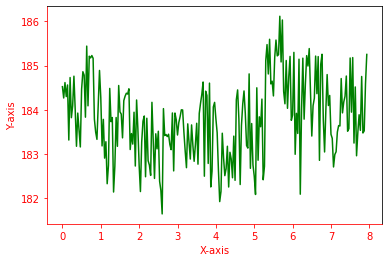

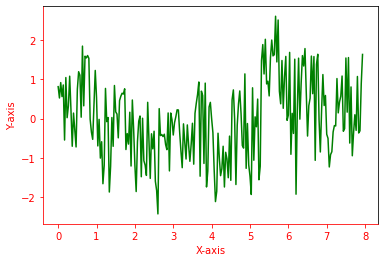

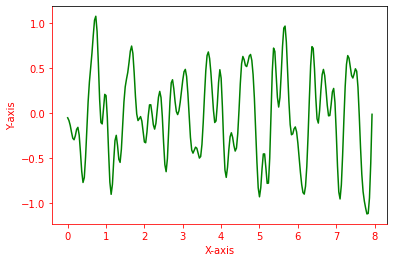

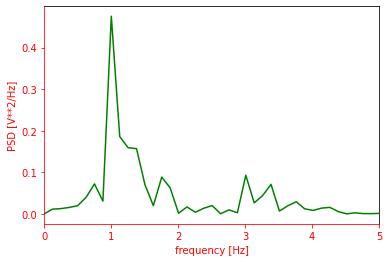

[2021-04-17 10:25:51,430] [INFO] [find_hr_in_window] [49] : Heart rate of window 1: 1.00418410041841


In [22]:
color_sig_array = np.asarray(color_sig)
red = color_sig_array[:,0]
green = color_sig_array[:,1]
blue = color_sig_array[:,2]

window_start = 0
window_size = 30
window_id = 0
limit = good_frame_number - int(round_fps) * window_size
while window_start < limit :
    find_hr_in_window(green, window_start, round_fps, window_id, window_size)
    window_start += int(round_fps) * window_size
    window_id += 1
if window_start < good_frame_number:
    window_id += 1
    find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

In [23]:
a = Pxx_den
ind = np.argsort(a)
max_ind = ind[-5:]
print(f[max_ind])
print("HR for this video is: " +str(f[max_ind].mean()))

NameError: name 'Pxx_den' is not defined

In [ ]:
if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

In [ ]:
if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'

In [ ]:
f, Pxx_den = sig.welch(green_buttered, round_fps,'flattop', 1024, scaling='spectrum')

### Plot final results

In [ ]:
plt.figure(f, Pxx_den)
#plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
# periodogram method:
f, Pxx_den = sig.periodogram(green_buttered, round_fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()